<a href="https://colab.research.google.com/github/AmiBuch/exp-forecasting-methods-personal/blob/main/scripts/iitd_report_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install darts
%pip install xarray[complete]
%matplotlib inline

In [ ]:
%pip install --quiet pytorch-lightning
%pip install --quiet tqdm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
import xarray as xr

# Dataset


## Slicing, Optimized Station Selection and Pruning NaN cols

In [ ]:
import xarray as xr
import pandas as pd
from sklearn.impute import KNNImputer
# Load dataset
ds = xr.open_dataset("delhi_jan.nc")

# Convert to pandas DataFrame
dataframe = ds.to_dataframe()

# Find the station with the least number of NaNs
nan_counts_per_station = dataframe.groupby(level='station').apply(lambda x: x.isna().sum().sum())
station_with_least_nans = nan_counts_per_station.idxmin()

# Select data for the station with the least number of NaNs
new_dataframe = dataframe.groupby(level='station').get_group(station_with_least_nans)

# Drop columns with all NaNs
col_to_drop = ["Eth-Benzene", "MP-Xylene", "O Xylene", "TOT-RF", "RF", "VWS", "state", "city", "address", "longitude", "latitude"]
new_dataframe.drop(columns=col_to_drop, inplace=True)

# Reset the index to prepare for KNN imputation
new_dataframe_reset = new_dataframe.reset_index()

# Select columns to impute (exclude non-numeric or unwanted columns)
print(new_dataframe_reset)


               Timestamp                    station    AT     BP  Benzene  \
0    2023-01-01 00:00:00  Mandir Marg, Delhi - DPCC   8.7  978.5      6.0   
1    2023-01-01 00:15:00  Mandir Marg, Delhi - DPCC   8.7  978.5      5.9   
2    2023-01-01 00:30:00  Mandir Marg, Delhi - DPCC   9.4  978.5      5.5   
3    2023-01-01 00:45:00  Mandir Marg, Delhi - DPCC   9.6  978.5      5.7   
4    2023-01-01 01:00:00  Mandir Marg, Delhi - DPCC   9.3  978.5      5.6   
...                  ...                        ...   ...    ...      ...   
2971 2023-01-31 22:45:00  Mandir Marg, Delhi - DPCC  14.3  978.3      1.8   
2972 2023-01-31 23:00:00  Mandir Marg, Delhi - DPCC  14.1  978.3      2.0   
2973 2023-01-31 23:15:00  Mandir Marg, Delhi - DPCC  14.4  978.3      2.5   
2974 2023-01-31 23:30:00  Mandir Marg, Delhi - DPCC  14.3  978.3      3.0   
2975 2023-01-31 23:45:00  Mandir Marg, Delhi - DPCC  14.3  978.3      3.3   

       CO   NH3    NO   NO2   NOx  Ozone   PM10  PM2.5    RH   SO2    SR  \

<ipython-input-6-b6a3d8ebd618>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe.drop(columns=col_to_drop, inplace=True)


# Data Preprocessing

## KNN Imputation

In [ ]:
columns_to_impute = new_dataframe_reset.select_dtypes(include=[float, int]).columns

# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the KNN imputer
imputed_data = knn_imputer.fit_transform(new_dataframe_reset[columns_to_impute])

# Convert the imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute, index=new_dataframe_reset.index)

# Restore the original DataFrame structure
new_dataframe_reset[columns_to_impute] = imputed_df

# Set the index back to original multi-index
imputed_final_df = new_dataframe_reset.set_index(['Timestamp', 'station'])
print(imputed_final_df.apply(lambda x: x.isna().sum().sum()))
# Initialize a dictionary to store the time series DataFrames
time_series_dict = {}

# Iterate over each column except 'PM2.5' and create DataFrames with 'PM2.5' and the current column
for column in imputed_final_df.columns:

        combined_df = imputed_final_df[[column]]
        time_series_dict[column] = combined_df

# Print the individual time series
for variable, series_df in time_series_dict.items():
    print(f"Time Series {variable}:")
    print(series_df)
    print()

AT         0
BP         0
Benzene    0
CO         0
NH3        0
NO         0
NO2        0
NOx        0
Ozone      0
PM10       0
PM2.5      0
RH         0
SO2        0
SR         0
Toluene    0
WD         0
WS         0
Xylene     0
dtype: int64
Time Series AT:
                                                 AT
Timestamp           station                        
2023-01-01 00:00:00 Mandir Marg, Delhi - DPCC   8.7
2023-01-01 00:15:00 Mandir Marg, Delhi - DPCC   8.7
2023-01-01 00:30:00 Mandir Marg, Delhi - DPCC   9.4
2023-01-01 00:45:00 Mandir Marg, Delhi - DPCC   9.6
2023-01-01 01:00:00 Mandir Marg, Delhi - DPCC   9.3
...                                             ...
2023-01-31 22:45:00 Mandir Marg, Delhi - DPCC  14.3
2023-01-31 23:00:00 Mandir Marg, Delhi - DPCC  14.1
2023-01-31 23:15:00 Mandir Marg, Delhi - DPCC  14.4
2023-01-31 23:30:00 Mandir Marg, Delhi - DPCC  14.3
2023-01-31 23:45:00 Mandir Marg, Delhi - DPCC  14.3

[2976 rows x 1 columns]

Time Series BP:
                   

## Extreme Values
### Remove values by 3sigma rule

## Normalization (Standardization)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler(feature_range = (0,1))

main_dict = {}
scalers = {}
main_df = mm.fit_transform(time_series_dict['PM2.5'].values)
main_df = pd.DataFrame(main_df, columns=time_series_dict['PM2.5'].columns, index=time_series_dict['PM2.5'].index)
for variable, series_df in time_series_dict.items():
    mm = MinMaxScaler(feature_range = (0,1))
    data_normalized = mm.fit_transform(series_df.values)
    data_normalized = pd.DataFrame(data_normalized, columns=series_df.columns, index=series_df.index)

    # print(data_normalized.head())

    series_df = data_normalized
    scalers[variable] = mm
    if variable!= 'PM2.5':
      combined_df = pd.concat([main_df, series_df], axis=1)
      main_dict[variable] = combined_df


print(main_dict)


{'AT':                                                   PM2.5        AT
Timestamp           station                                      
2023-01-01 00:00:00 Mandir Marg, Delhi - DPCC  0.278119  0.245791
2023-01-01 00:15:00 Mandir Marg, Delhi - DPCC  0.278119  0.245791
2023-01-01 00:30:00 Mandir Marg, Delhi - DPCC  0.278119  0.269360
2023-01-01 00:45:00 Mandir Marg, Delhi - DPCC  0.286299  0.276094
2023-01-01 01:00:00 Mandir Marg, Delhi - DPCC  0.286299  0.265993
...                                                 ...       ...
2023-01-31 22:45:00 Mandir Marg, Delhi - DPCC  0.177914  0.434343
2023-01-31 23:00:00 Mandir Marg, Delhi - DPCC  0.177914  0.427609
2023-01-31 23:15:00 Mandir Marg, Delhi - DPCC  0.177914  0.437710
2023-01-31 23:30:00 Mandir Marg, Delhi - DPCC  0.177914  0.434343
2023-01-31 23:45:00 Mandir Marg, Delhi - DPCC  0.202454  0.434343

[2976 rows x 2 columns], 'BP':                                                   PM2.5        BP
Timestamp           station          

# Models

## LSTM-RNN


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 15s 128ms/step - loss: 0.0204 - val_loss: 0.0101
Epoch 2/50
 1/74 [..............................] - ETA: 7s - loss: 0.0119

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 118ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 3/50
74/74 [==============================] - 7s 95ms/step - loss: 0.0081 - val_loss: 0.0048
Epoch 4/50
74/74 [==============================] - 9s 125ms/step - loss: 0.0073 - val_loss: 0.0046
Epoch 5/50
74/74 [==============================] - 7s 95ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 6/50
74/74 [==============================] - 9s 120ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 7/50
74/74 [==============================] - 8s 110ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 8/50
74/74 [==============================] - 8s 105ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 9/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 10/50
74/74 [==============================] - 8s 108ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 11/50
74/74 [==============================] - 12s 168ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 12/5

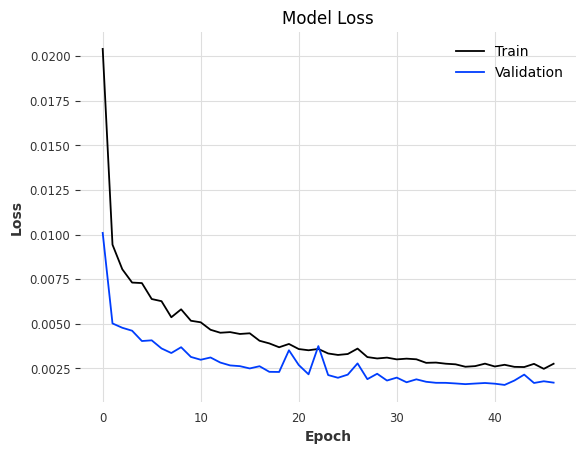

19/19 [==============================] - 2s 35ms/step
Mean Absolute Error (MAE): 12.349267185307468
Mean Squared Error (MSE): 468.8994283751108
Root Mean Squared Error (RMSE): 21.65408572013861


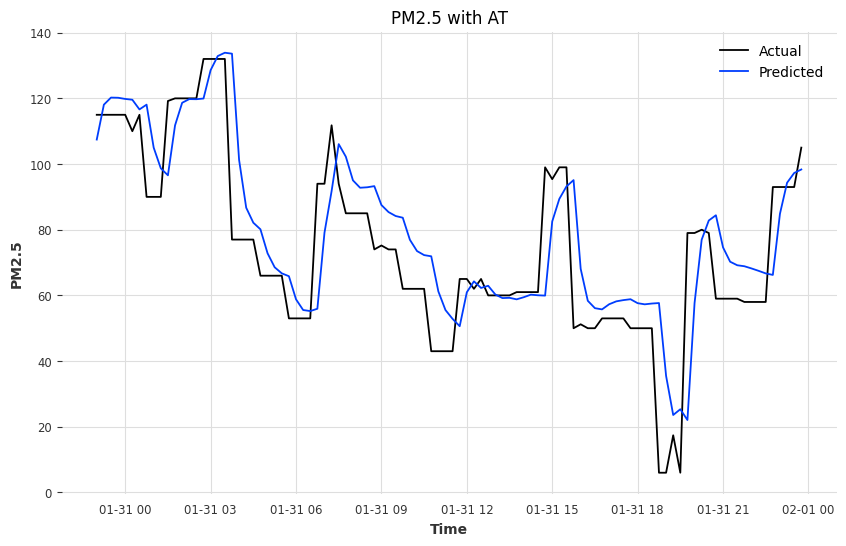

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 16s 134ms/step - loss: 0.0250 - val_loss: 0.0119
Epoch 2/50
 1/74 [..............................] - ETA: 10s - loss: 0.0115

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 8s 102ms/step - loss: 0.0116 - val_loss: 0.0104
Epoch 3/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 4/50
74/74 [==============================] - 7s 101ms/step - loss: 0.0080 - val_loss: 0.0050
Epoch 5/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 6/50
74/74 [==============================] - 9s 120ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 7/50
74/74 [==============================] - 8s 105ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 8/50
74/74 [==============================] - 9s 124ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 9/50
74/74 [==============================] - 8s 111ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 10/50
74/74 [==============================] - 9s 118ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 11/50
74/74 [==============================] - 9s 124ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 12/

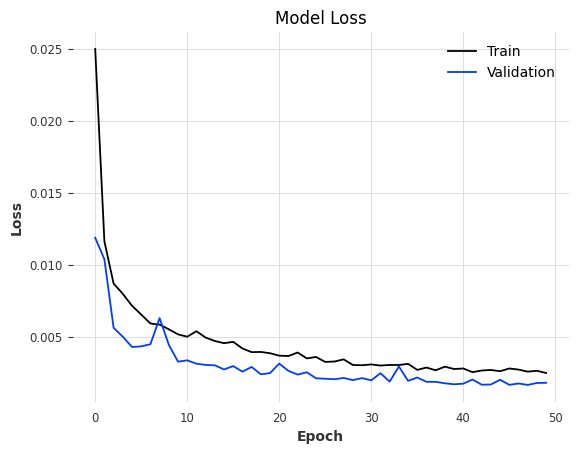

19/19 [==============================] - 3s 63ms/step
Mean Absolute Error (MAE): 12.241231033579766
Mean Squared Error (MSE): 482.41411492493086
Root Mean Squared Error (RMSE): 21.963927584221608


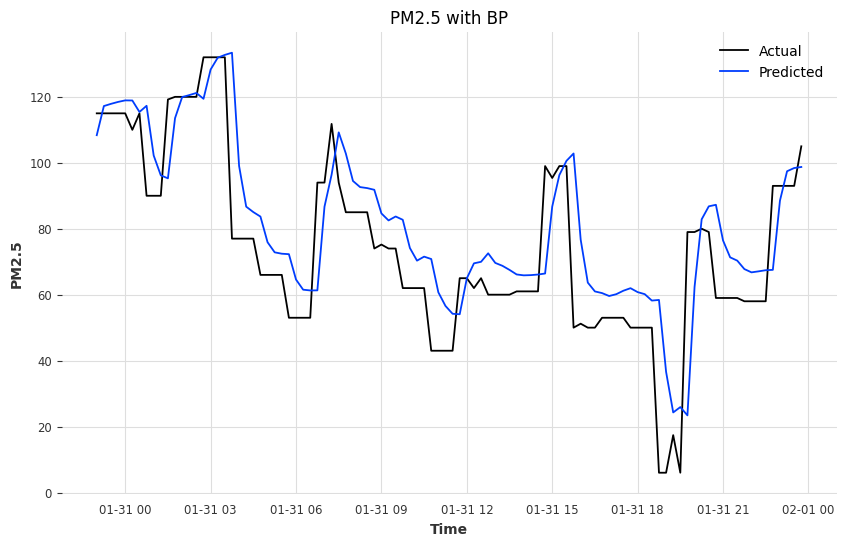

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 17s 139ms/step - loss: 0.0214 - val_loss: 0.0130
Epoch 2/50
 1/74 [..............................] - ETA: 6s - loss: 0.0156

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 117ms/step - loss: 0.0104 - val_loss: 0.0060
Epoch 3/50
74/74 [==============================] - 8s 107ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 4/50
74/74 [==============================] - 9s 122ms/step - loss: 0.0075 - val_loss: 0.0054
Epoch 5/50
74/74 [==============================] - 7s 101ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 6/50
74/74 [==============================] - 9s 124ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 7/50
74/74 [==============================] - 9s 117ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 8/50
74/74 [==============================] - 8s 107ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 9/50
74/74 [==============================] - 9s 125ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 10/50
74/74 [==============================] - 7s 100ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 11/50
74/74 [==============================] - 9s 125ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 12/

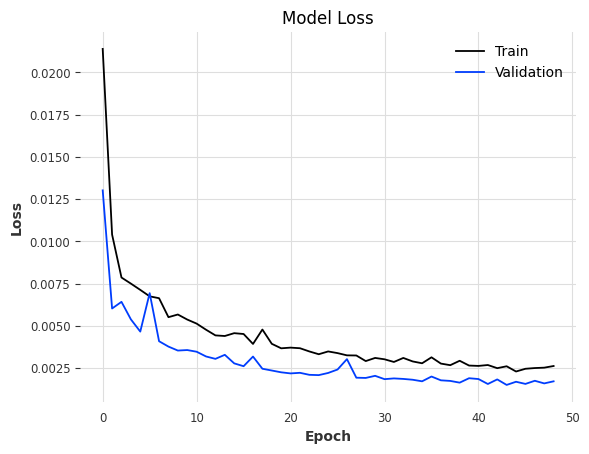

19/19 [==============================] - 2s 35ms/step
Mean Absolute Error (MAE): 11.317042387205335
Mean Squared Error (MSE): 452.667105524
Root Mean Squared Error (RMSE): 21.275974843094733


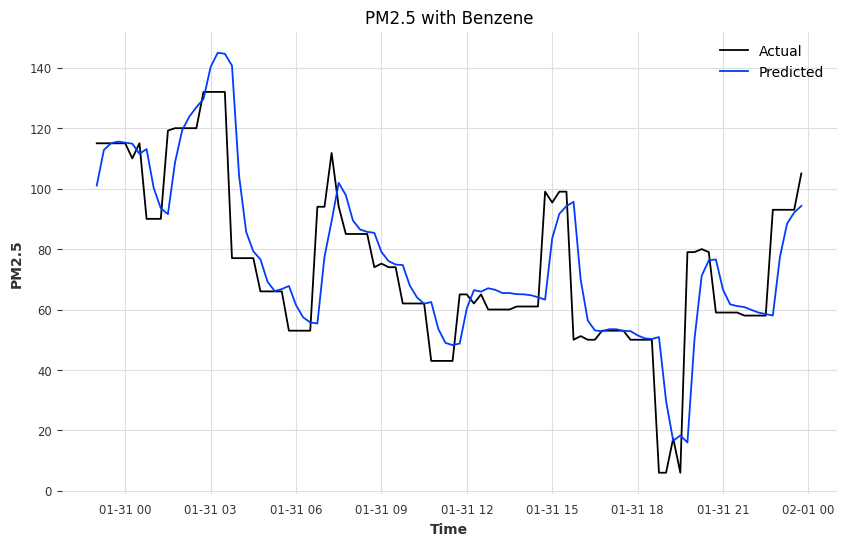

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 15s 117ms/step - loss: 0.0207 - val_loss: 0.0076
Epoch 2/50
 1/74 [..............................] - ETA: 6s - loss: 0.0106

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 120ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 3/50
74/74 [==============================] - 9s 118ms/step - loss: 0.0082 - val_loss: 0.0073
Epoch 4/50
74/74 [==============================] - 7s 99ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 5/50
74/74 [==============================] - 9s 123ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 6/50
74/74 [==============================] - 7s 98ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 7/50
74/74 [==============================] - 9s 119ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 8/50
74/74 [==============================] - 8s 113ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 9/50
74/74 [==============================] - 8s 106ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 10/50
74/74 [==============================] - 9s 123ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 11/50
74/74 [==============================] - 7s 99ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 12/50


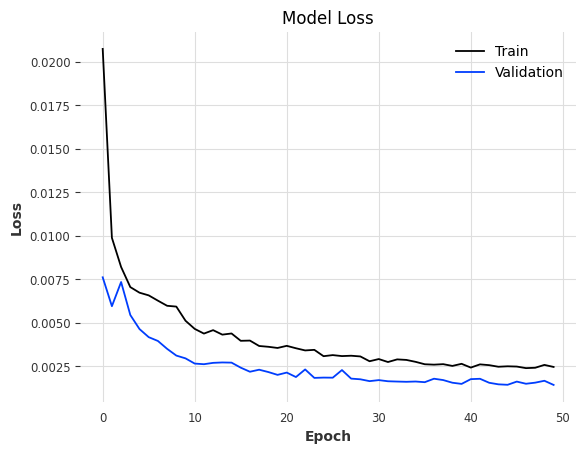

19/19 [==============================] - 2s 37ms/step
Mean Absolute Error (MAE): 11.503366659722207
Mean Squared Error (MSE): 449.7503699748878
Root Mean Squared Error (RMSE): 21.207318783261776


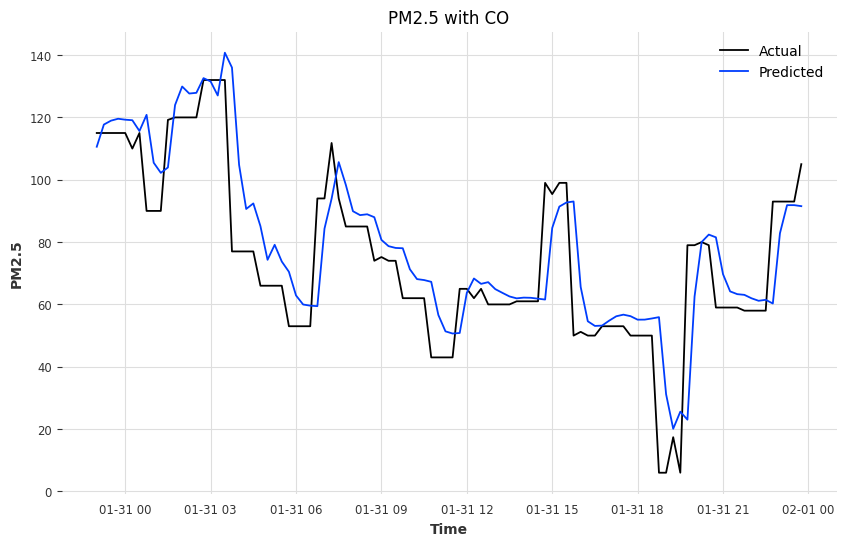

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 18s 149ms/step - loss: 0.0212 - val_loss: 0.0101
Epoch 2/50
 1/74 [..............................] - ETA: 6s - loss: 0.0109

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 8s 106ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 3/50
74/74 [==============================] - 10s 130ms/step - loss: 0.0084 - val_loss: 0.0119
Epoch 4/50
74/74 [==============================] - 9s 127ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 5/50
74/74 [==============================] - 8s 106ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 6/50
74/74 [==============================] - 10s 130ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 7/50
74/74 [==============================] - 8s 113ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 8/50
74/74 [==============================] - 9s 124ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 9/50
74/74 [==============================] - 10s 130ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 10/50
74/74 [==============================] - 8s 114ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 11/50
74/74 [==============================] - 9s 122ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 

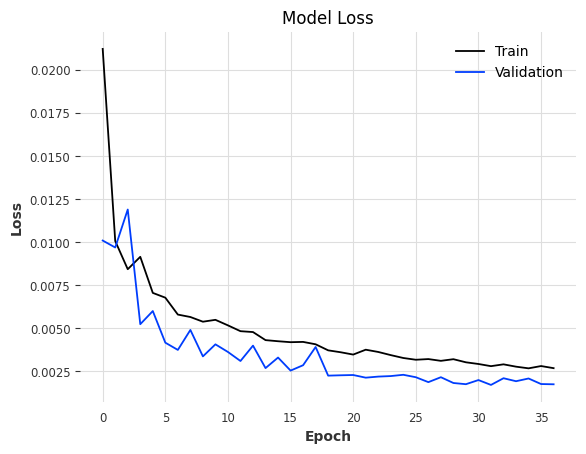

19/19 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 12.306218318560628
Mean Squared Error (MSE): 483.54763462719825
Root Mean Squared Error (RMSE): 21.989716565412984


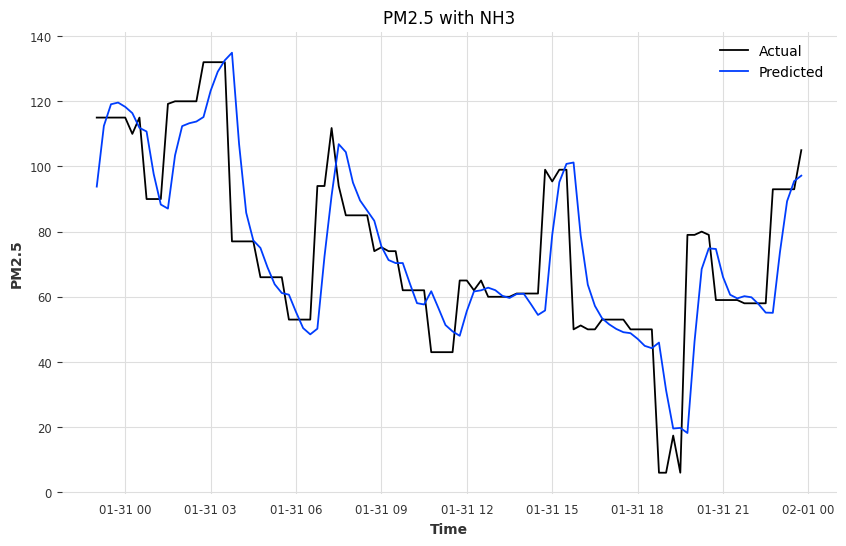

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 16s 130ms/step - loss: 0.0194 - val_loss: 0.0070
Epoch 2/50
 1/74 [..............................] - ETA: 6s - loss: 0.0099

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 123ms/step - loss: 0.0092 - val_loss: 0.0049
Epoch 3/50
74/74 [==============================] - 7s 101ms/step - loss: 0.0080 - val_loss: 0.0050
Epoch 4/50
74/74 [==============================] - 9s 125ms/step - loss: 0.0080 - val_loss: 0.0041
Epoch 5/50
74/74 [==============================] - 8s 114ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 6/50
74/74 [==============================] - 8s 109ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 7/50
74/74 [==============================] - 9s 124ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 8/50
74/74 [==============================] - 7s 101ms/step - loss: 0.0056 - val_loss: 0.0060
Epoch 9/50
74/74 [==============================] - 9s 125ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 10/50
74/74 [==============================] - 8s 111ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 11/50
74/74 [==============================] - 8s 114ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 12/

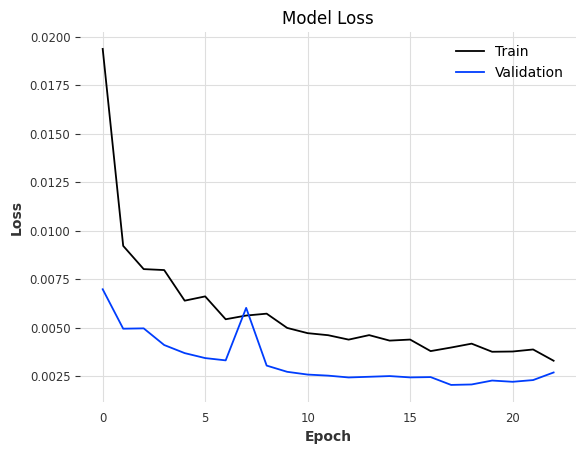

19/19 [==============================] - 3s 61ms/step
Mean Absolute Error (MAE): 16.851011600703725
Mean Squared Error (MSE): 654.0376259601866
Root Mean Squared Error (RMSE): 25.574159340243945


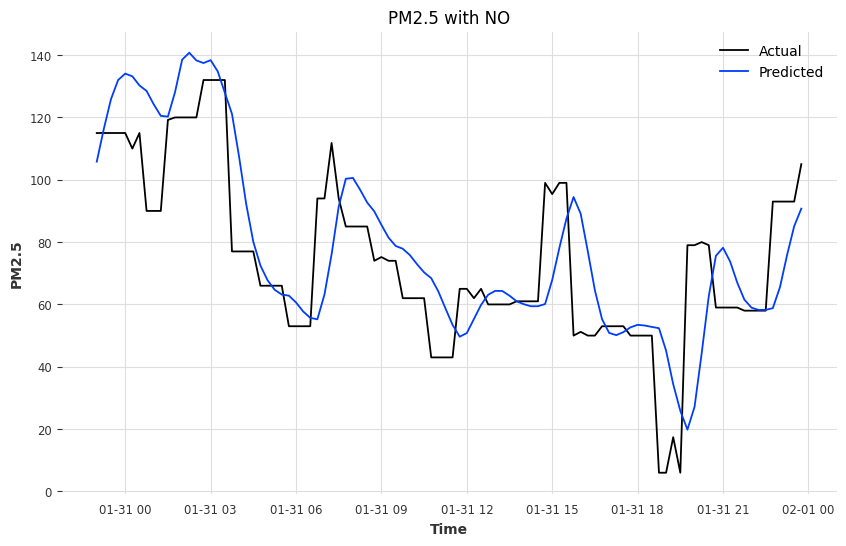

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 16s 147ms/step - loss: 0.0235 - val_loss: 0.0160
Epoch 2/50
 1/74 [..............................] - ETA: 7s - loss: 0.0187

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 126ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 3/50
74/74 [==============================] - 8s 105ms/step - loss: 0.0098 - val_loss: 0.0059
Epoch 4/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 5/50
74/74 [==============================] - 8s 113ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 6/50
74/74 [==============================] - 9s 117ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 7/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 8/50
74/74 [==============================] - 8s 104ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 9/50
74/74 [==============================] - 10s 139ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 10/50
74/74 [==============================] - 9s 129ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 11/50
74/74 [==============================] - 8s 105ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 12

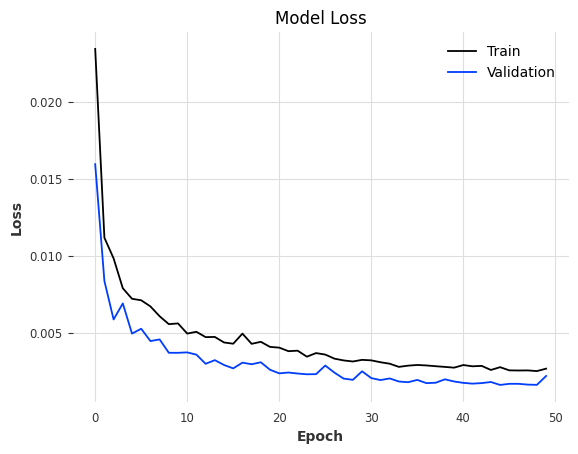

19/19 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 11.089175275584708
Mean Squared Error (MSE): 473.6881906278433
Root Mean Squared Error (RMSE): 21.764378939630767


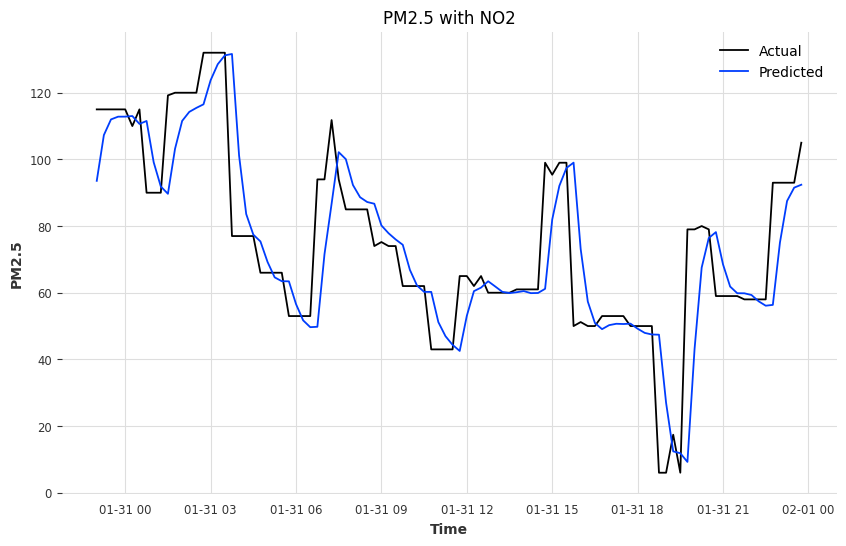

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 16s 143ms/step - loss: 0.0199 - val_loss: 0.0080
Epoch 2/50
 1/74 [..............................] - ETA: 7s - loss: 0.0046

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 125ms/step - loss: 0.0095 - val_loss: 0.0058
Epoch 3/50
74/74 [==============================] - 7s 101ms/step - loss: 0.0078 - val_loss: 0.0045
Epoch 4/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0080 - val_loss: 0.0043
Epoch 5/50
74/74 [==============================] - 8s 102ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 6/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 7/50
74/74 [==============================] - 9s 119ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 8/50
74/74 [==============================] - 8s 103ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 9/50
74/74 [==============================] - 9s 121ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 10/50
74/74 [==============================] - 8s 102ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 11/50
74/74 [==============================] - 9s 122ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 12/

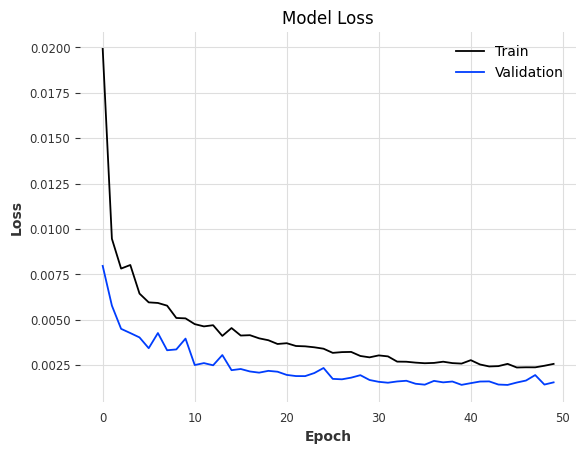

19/19 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 12.128611543655403
Mean Squared Error (MSE): 450.09450475867334
Root Mean Squared Error (RMSE): 21.215430817182888


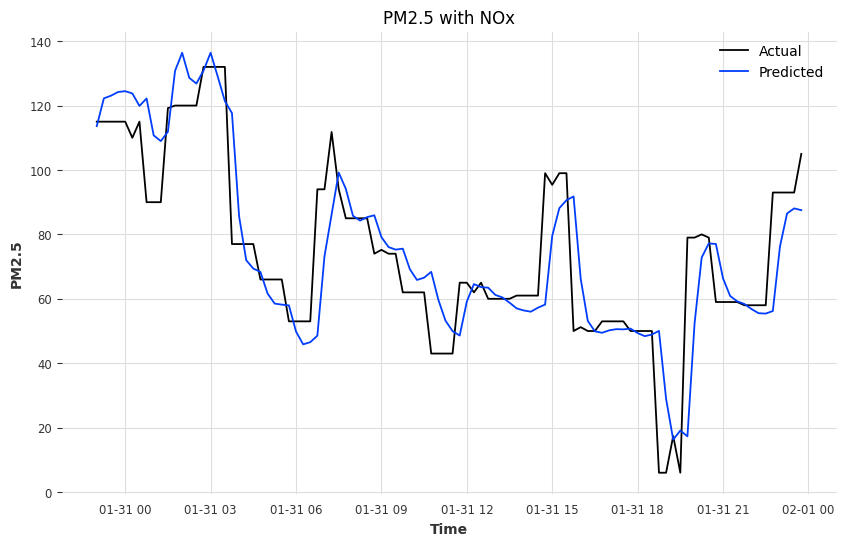

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 19s 145ms/step - loss: 0.0210 - val_loss: 0.0086
Epoch 2/50
 1/74 [..............................] - ETA: 7s - loss: 0.0180

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 10s 132ms/step - loss: 0.0095 - val_loss: 0.0059
Epoch 3/50
74/74 [==============================] - 8s 111ms/step - loss: 0.0081 - val_loss: 0.0053
Epoch 4/50
74/74 [==============================] - 9s 123ms/step - loss: 0.0075 - val_loss: 0.0046
Epoch 5/50
74/74 [==============================] - 9s 129ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 6/50
74/74 [==============================] - 8s 106ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 7/50
74/74 [==============================] - 10s 131ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 8/50
74/74 [==============================] - 10s 129ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 9/50
74/74 [==============================] - 8s 106ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 10/50
74/74 [==============================] - 10s 132ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 11/50
74/74 [==============================] - 8s 109ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch

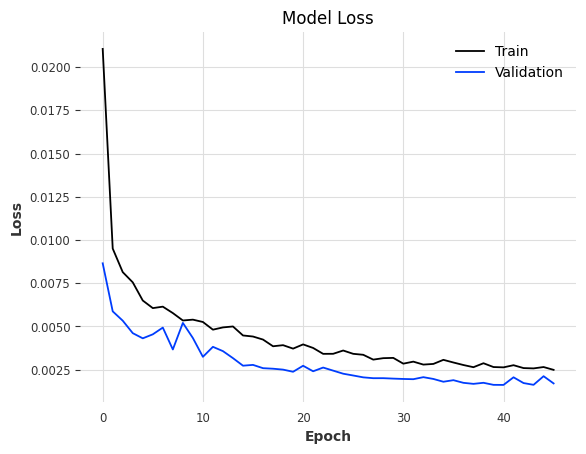

19/19 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 12.04541131303897
Mean Squared Error (MSE): 471.79835694930307
Root Mean Squared Error (RMSE): 21.720919799799066


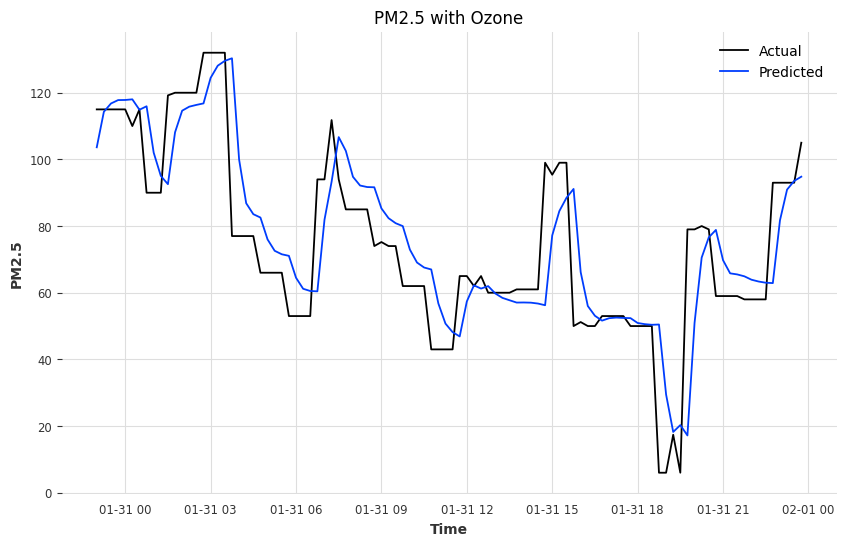

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 15s 119ms/step - loss: 0.0209 - val_loss: 0.0083
Epoch 2/50
 1/74 [..............................] - ETA: 8s - loss: 0.0076

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 128ms/step - loss: 0.0096 - val_loss: 0.0061
Epoch 3/50
74/74 [==============================] - 8s 115ms/step - loss: 0.0084 - val_loss: 0.0053
Epoch 4/50
74/74 [==============================] - 8s 113ms/step - loss: 0.0072 - val_loss: 0.0044
Epoch 5/50
74/74 [==============================] - 9s 128ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 6/50
74/74 [==============================] - 8s 102ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 7/50
74/74 [==============================] - 9s 128ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 8/50
74/74 [==============================] - 8s 113ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 9/50
74/74 [==============================] - 9s 117ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 10/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 11/50
74/74 [==============================] - 8s 103ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 12/

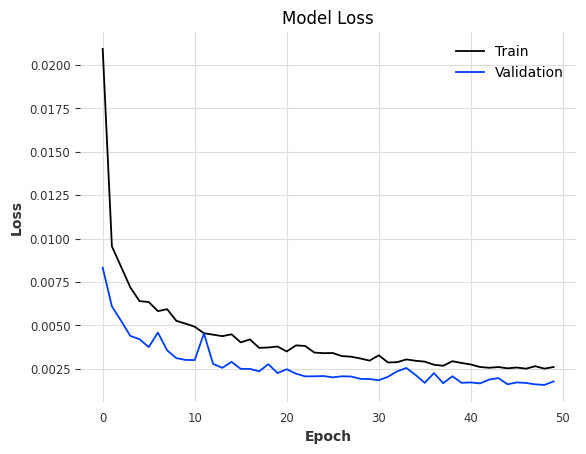

19/19 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 10.577171942885785
Mean Squared Error (MSE): 464.0027208170238
Root Mean Squared Error (RMSE): 21.540722383825102


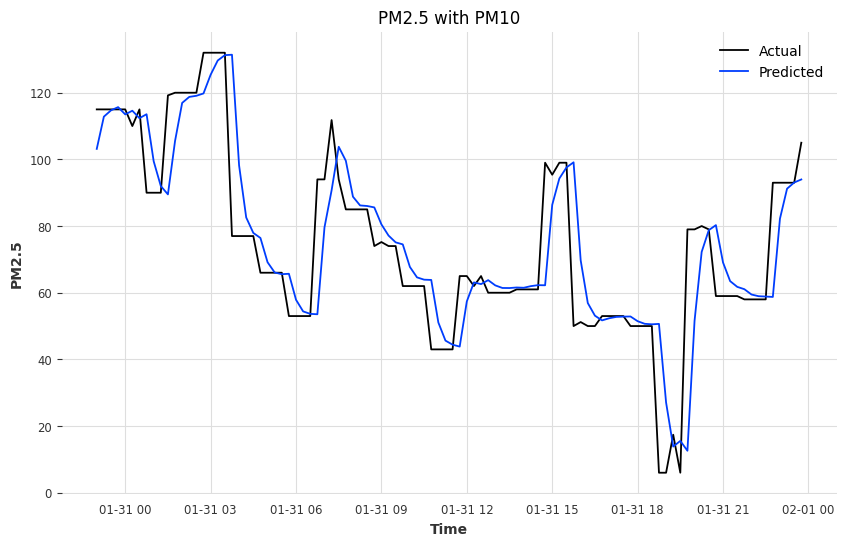

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 19s 157ms/step - loss: 0.0226 - val_loss: 0.0089
Epoch 2/50
 1/74 [..............................] - ETA: 8s - loss: 0.0187

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 123ms/step - loss: 0.0111 - val_loss: 0.0081
Epoch 3/50
74/74 [==============================] - 10s 130ms/step - loss: 0.0085 - val_loss: 0.0053
Epoch 4/50
74/74 [==============================] - 10s 136ms/step - loss: 0.0082 - val_loss: 0.0054
Epoch 5/50
74/74 [==============================] - 10s 129ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 6/50
74/74 [==============================] - 9s 125ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 7/50
74/74 [==============================] - 10s 140ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 8/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 9/50
74/74 [==============================] - 9s 127ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 10/50
74/74 [==============================] - 10s 139ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 11/50
74/74 [==============================] - 10s 131ms/step - loss: 0.0053 - val_loss: 0.0033
Epo

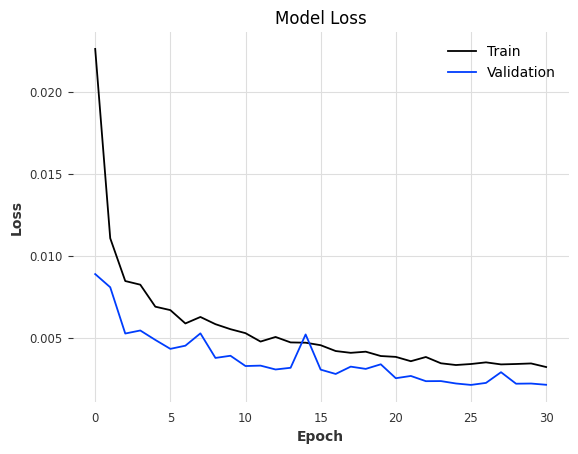

19/19 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 15.204961000983158
Mean Squared Error (MSE): 583.9003104550887
Root Mean Squared Error (RMSE): 24.16402926779987


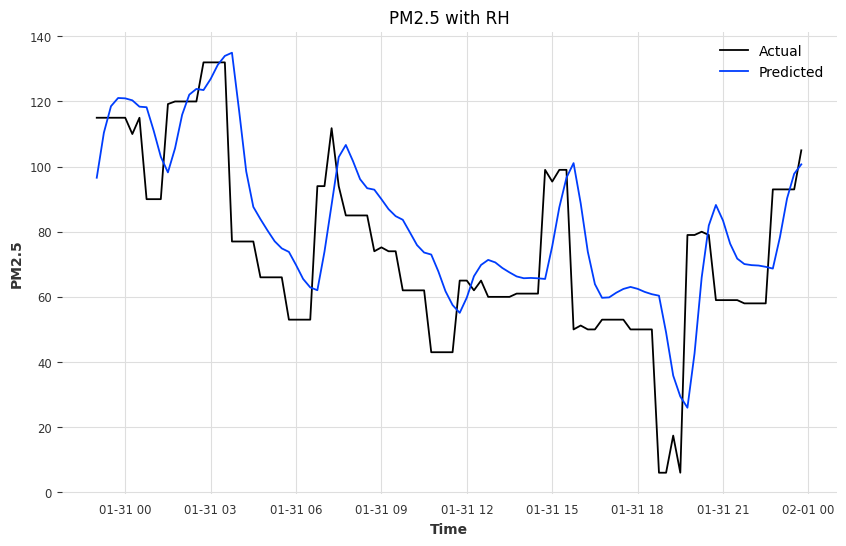

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 16s 138ms/step - loss: 0.0192 - val_loss: 0.0087
Epoch 2/50
 1/74 [..............................] - ETA: 7s - loss: 0.0072

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 8s 105ms/step - loss: 0.0100 - val_loss: 0.0074
Epoch 3/50
74/74 [==============================] - 10s 129ms/step - loss: 0.0081 - val_loss: 0.0050
Epoch 4/50
74/74 [==============================] - 8s 112ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 5/50
74/74 [==============================] - 9s 120ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 6/50
74/74 [==============================] - 10s 129ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 7/50
74/74 [==============================] - 8s 103ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 8/50
74/74 [==============================] - 9s 128ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 9/50
74/74 [==============================] - 8s 106ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 10/50
74/74 [==============================] - 9s 124ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 11/50
74/74 [==============================] - 9s 122ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 1

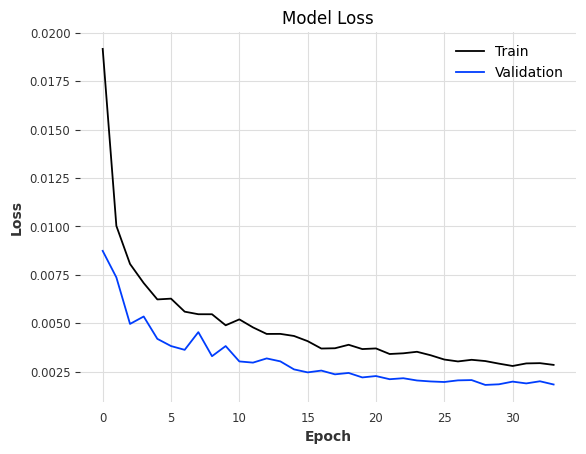

19/19 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 12.81581488226543
Mean Squared Error (MSE): 507.73600211164
Root Mean Squared Error (RMSE): 22.532998071975243


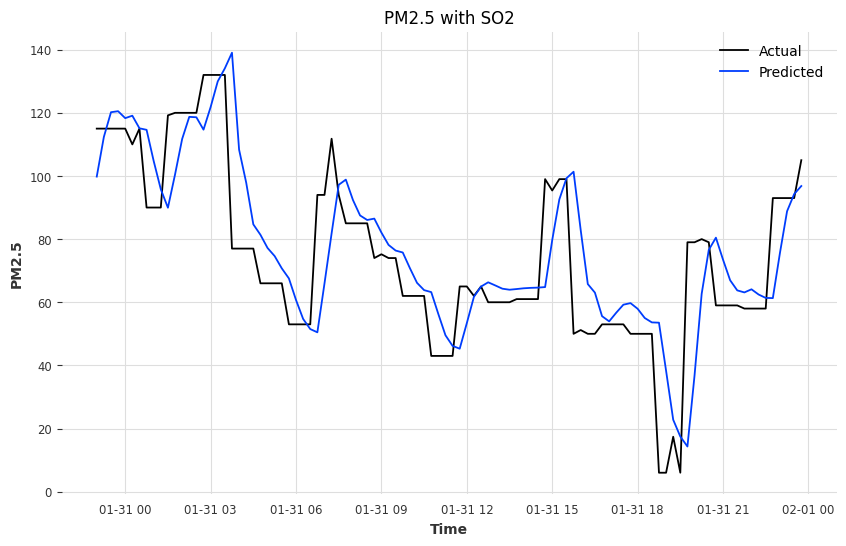

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 16s 125ms/step - loss: 0.0234 - val_loss: 0.0091
Epoch 2/50
 1/74 [..............................] - ETA: 7s - loss: 0.0138

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 10s 130ms/step - loss: 0.0102 - val_loss: 0.0066
Epoch 3/50
74/74 [==============================] - 8s 105ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 4/50
74/74 [==============================] - 9s 124ms/step - loss: 0.0080 - val_loss: 0.0049
Epoch 5/50
74/74 [==============================] - 9s 123ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 6/50
74/74 [==============================] - 8s 103ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 7/50
74/74 [==============================] - 9s 128ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 8/50
74/74 [==============================] - 8s 113ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 9/50
74/74 [==============================] - 9s 116ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 10/50
74/74 [==============================] - 10s 130ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 11/50
74/74 [==============================] - 8s 104ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 1

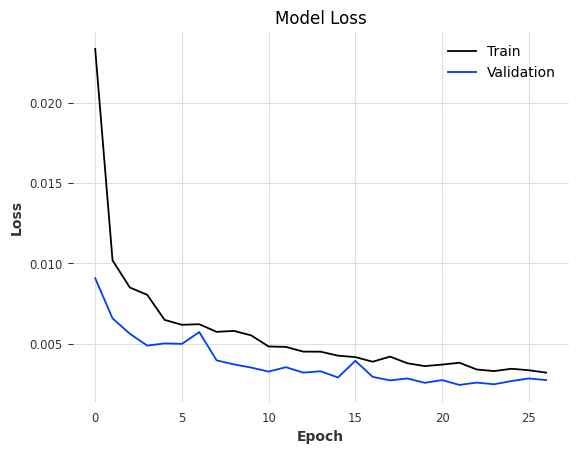

19/19 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 16.580544158049204
Mean Squared Error (MSE): 618.6469473333399
Root Mean Squared Error (RMSE): 24.872614404869864


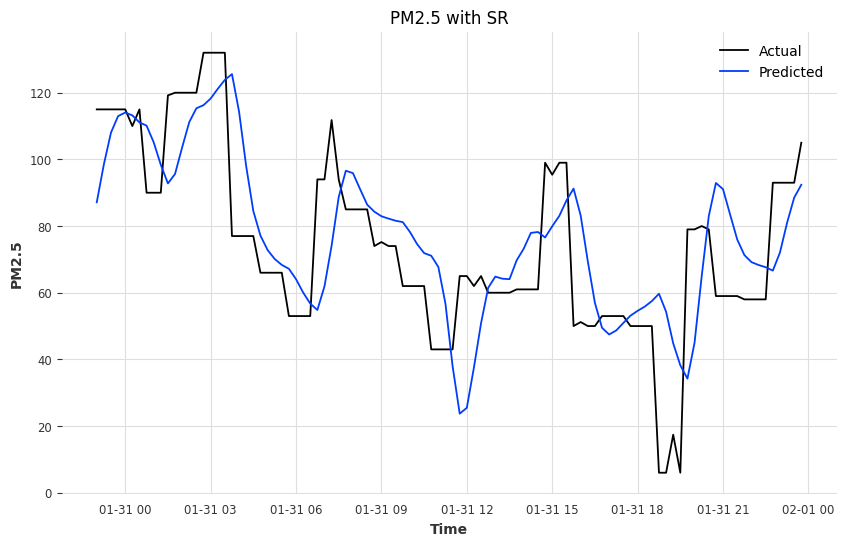

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 17s 155ms/step - loss: 0.0225 - val_loss: 0.0093
Epoch 2/50
 1/74 [..............................] - ETA: 8s - loss: 0.0195

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 8s 115ms/step - loss: 0.0099 - val_loss: 0.0107
Epoch 3/50
74/74 [==============================] - 10s 134ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 4/50
74/74 [==============================] - 10s 137ms/step - loss: 0.0075 - val_loss: 0.0048
Epoch 5/50
74/74 [==============================] - 8s 115ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 6/50
74/74 [==============================] - 10s 140ms/step - loss: 0.0069 - val_loss: 0.0041
Epoch 7/50
74/74 [==============================] - 10s 132ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 8/50
74/74 [==============================] - 9s 117ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 9/50
74/74 [==============================] - 10s 139ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 10/50
74/74 [==============================] - 10s 129ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 11/50
74/74 [==============================] - 9s 120ms/step - loss: 0.0051 - val_loss: 0.0036
Epo

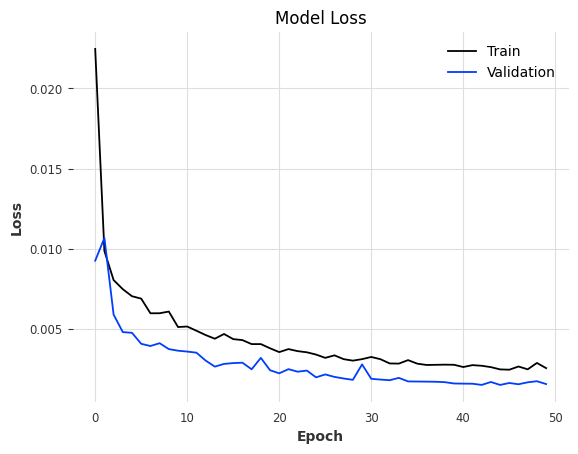

19/19 [==============================] - 2s 51ms/step
Mean Absolute Error (MAE): 11.38260785449299
Mean Squared Error (MSE): 459.2306678651152
Root Mean Squared Error (RMSE): 21.42966793641738


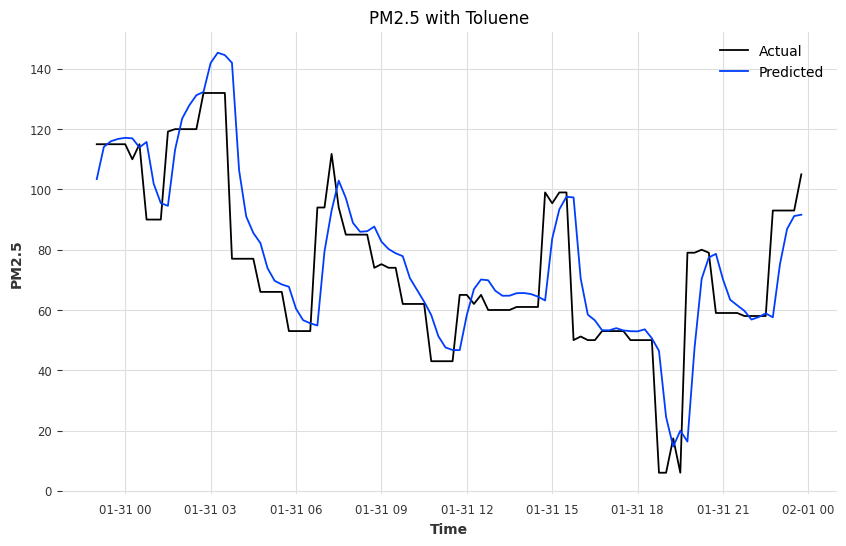

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 16s 143ms/step - loss: 0.0235 - val_loss: 0.0087
Epoch 2/50
 1/74 [..............................] - ETA: 8s - loss: 0.0159

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 8s 108ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 3/50
74/74 [==============================] - 10s 134ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 4/50
74/74 [==============================] - 8s 112ms/step - loss: 0.0072 - val_loss: 0.0053
Epoch 5/50
74/74 [==============================] - 9s 126ms/step - loss: 0.0075 - val_loss: 0.0064
Epoch 6/50
74/74 [==============================] - 10s 129ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 7/50
74/74 [==============================] - 8s 108ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 8/50
74/74 [==============================] - 10s 131ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 9/50
74/74 [==============================] - 9s 123ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 10/50
74/74 [==============================] - 9s 117ms/step - loss: 0.0054 - val_loss: 0.0039
Epoch 11/50
74/74 [==============================] - 10s 134ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch

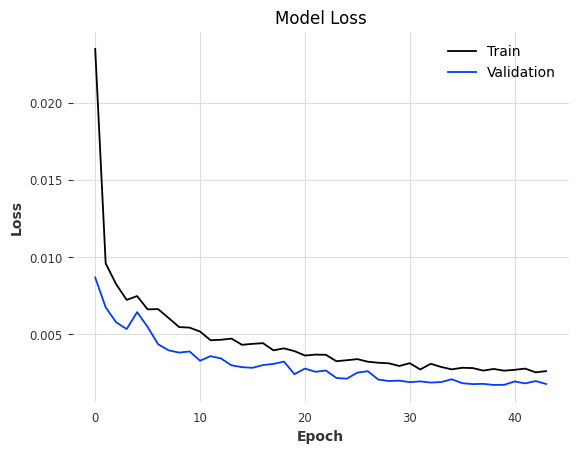

19/19 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 11.455447521484842
Mean Squared Error (MSE): 464.7606689426563
Root Mean Squared Error (RMSE): 21.558308582601192


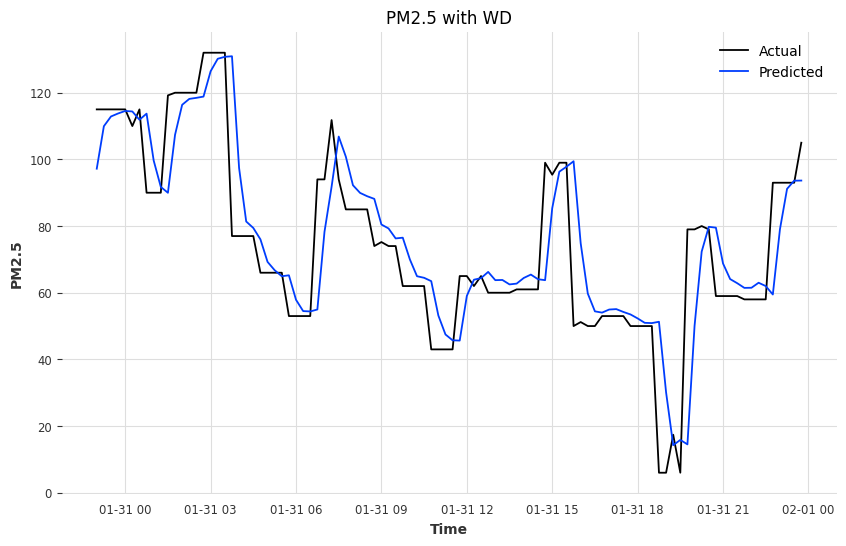

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 16s 132ms/step - loss: 0.0237 - val_loss: 0.0086
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 124ms/step - loss: 0.0113 - val_loss: 0.0060
Epoch 3/50
74/74 [==============================] - 9s 128ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 4/50
74/74 [==============================] - 8s 108ms/step - loss: 0.0081 - val_loss: 0.0055
Epoch 5/50
74/74 [==============================] - 10s 134ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 6/50
74/74 [==============================] - 9s 119ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 7/50
74/74 [==============================] - 9s 122ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 8/50
74/74 [==============================] - 10s 134ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 9/50
74/74 [==============================] - 8s 108ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 10/50
74/74 [==============================] - 10s 129ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 11/50
74/74 [==============================] - 9s 125ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 

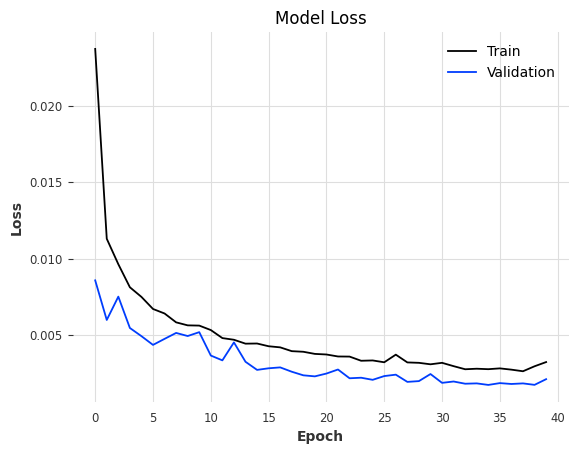

19/19 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 12.210603829518675
Mean Squared Error (MSE): 478.6987159119989
Root Mean Squared Error (RMSE): 21.879184534895238


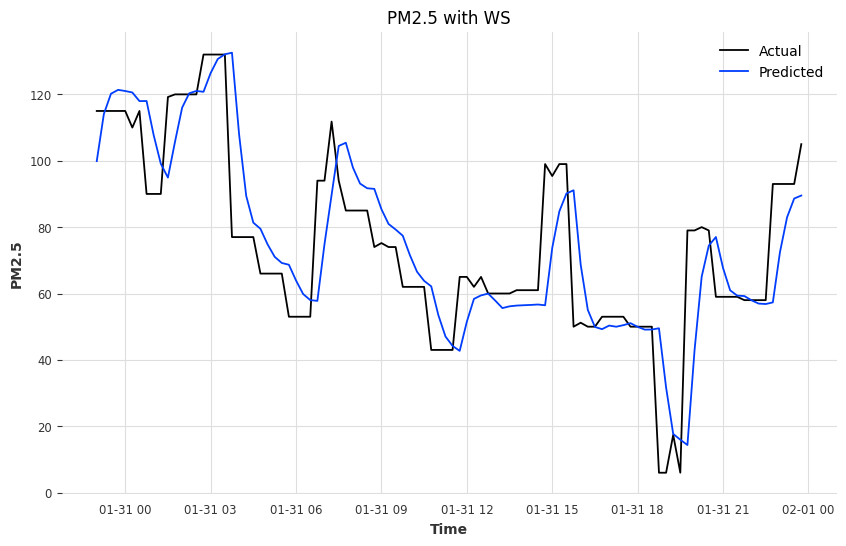

Train X shape: (2342, 48, 2)
Train Y shape: (2342,)
Test X shape: (586, 48, 2)
Test Y shape: (586,)
Epoch 1/50
74/74 [==============================] - 16s 134ms/step - loss: 0.0217 - val_loss: 0.0081
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 123ms/step - loss: 0.0101 - val_loss: 0.0067
Epoch 3/50
74/74 [==============================] - 10s 135ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 4/50
74/74 [==============================] - 8s 111ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 5/50
74/74 [==============================] - 10s 135ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 6/50
74/74 [==============================] - 10s 130ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 7/50
74/74 [==============================] - 8s 112ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 8/50
74/74 [==============================] - 10s 131ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 9/50
74/74 [==============================] - 9s 129ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 10/50
74/74 [==============================] - 9s 117ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 11/50
74/74 [==============================] - 10s 136ms/step - loss: 0.0050 - val_loss: 0.0035
Epoc

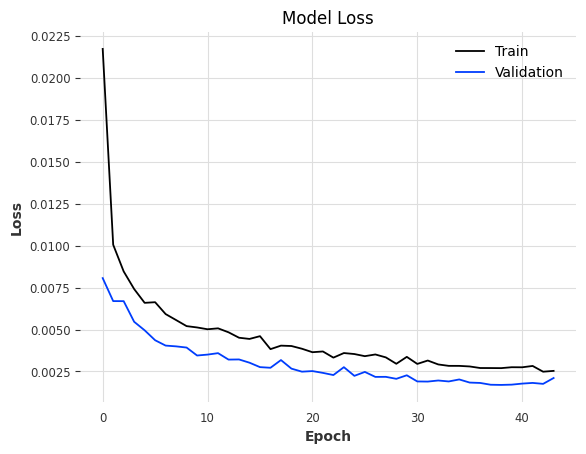

19/19 [==============================] - 3s 63ms/step
Mean Absolute Error (MAE): 12.122810754854125
Mean Squared Error (MSE): 464.714131896451
Root Mean Squared Error (RMSE): 21.55722922586414


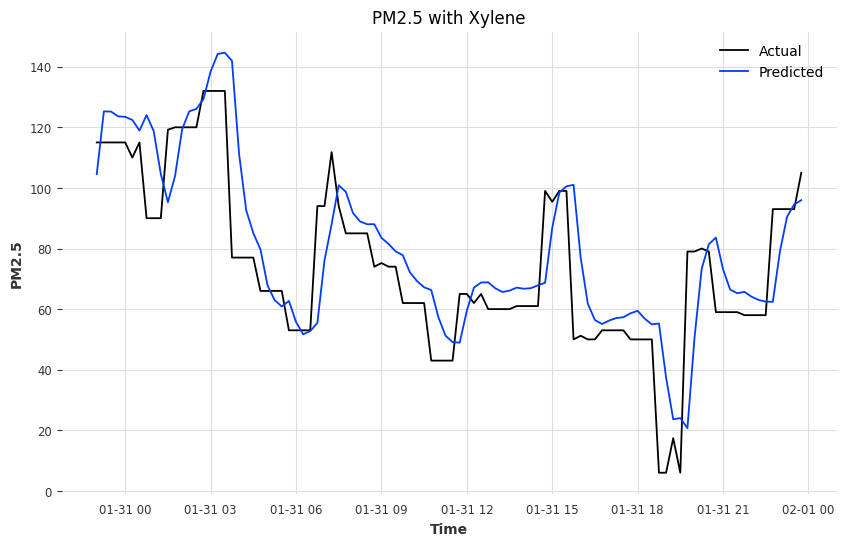

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
for variable, scaled_data in main_dict.items():

  sequences = []
  labels = []
  sequence_length = 48
  num_features = 2
  for i in range(len(scaled_data) - sequence_length):
      seq = scaled_data[i:i+sequence_length]
      label = scaled_data['PM2.5'][i+sequence_length]  # '_tempm' column index
      sequences.append(seq)
      labels.append(label)

  # Convert to numpy arrays
  sequences = np.array(sequences)
  labels = np.array(labels)

  # Split into train and test sets
  train_size = int(0.8 * len(sequences))
  train_x, test_x = sequences[:train_size], sequences[train_size:]
  train_y, test_y = labels[:train_size], labels[train_size:]

  print("Train X shape:", train_x.shape)
  print("Train Y shape:", train_y.shape)
  print("Test X shape:", test_x.shape)
  print("Test Y shape:", test_y.shape)


  # Create the LSTM model
  model = Sequential()

  # Add LSTM layers with dropout
  model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=64, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=32, return_sequences=False))
  model.add(Dropout(0.2))

  # Add a dense output layer
  model.add(Dense(units=1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')
  # Train the model
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/dl/weather_prediction/best_model_weights.h5', monitor='val_loss', save_best_only=True)
  history = model.fit(
    train_x, train_y,
    epochs=50,
    batch_size=24,
    validation_split=0.25,  # Use part of the training data as validation
    callbacks=[early_stopping, model_checkpoint]

  )
  # Evaluate the best model on the test set
  best_model = keras.models.load_model('/content/drive/MyDrive/dl/weather_prediction/best_model_weights.h5')
  test_loss = best_model.evaluate(test_x, test_y)
  print("Test Loss:", test_loss)
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()
  # Predict temperatures using the trained model
  predictions = best_model.predict(test_x)
  true_predict = scalers['PM2.5'].inverse_transform(predictions)
  test_y = test_y.reshape(-1,1)
  true_pm = scalers['PM2.5'].inverse_transform(test_y)
  # Calculate evaluation metrics
  mae = mean_absolute_error(true_pm, true_predict)
  mse = mean_squared_error(true_pm, true_predict)
  rmse = np.sqrt(mse)

  print("Mean Absolute Error (MAE):", mae)
  print("Mean Squared Error (MSE):", mse)
  print("Root Mean Squared Error (RMSE):", rmse)
  # y_true values
  # Plotting predicted and actual temperatures
  plt.figure(figsize=(10, 6))
  plt.plot(scaled_data.tail(100).index.get_level_values('Timestamp'), true_pm[-100:], label='Actual')
  plt.plot(scaled_data.tail(100).index.get_level_values('Timestamp'), true_predict[-100:], label='Predicted')
  plt.title('PM2.5 with ' + variable)
  plt.xlabel('Time')
  plt.ylabel('PM2.5')
  plt.legend()
  plt.show()
